# Across-State-Visits Testing with [glhmm toolbox](https://github.com/vidaurre/glhmm)

In this tutorial, we are going to look at how to implement the across-visits testing using the [glhmm toolbox](https://github.com/vidaurre/glhmm).

In the real world scenarios, one would typically fit a Hidden Markov Model (HMM) to an actual dataset. However, for the sake of showing the concept of statistical testing, we just use synthetic data for both the independent variable and the dependent variable for the ```across-visits``` test.

First, we'll load the synthetic data (```sig_data```) [here](https://github.com/vidaurre/glhmm/tree/main/docs/notebooks/data_statistical_testing) and use the [glhmm toolbox](https://github.com/vidaurre/glhmm) to fit a Hidden Markov Model (HMM) to the signal. The Viterbi path is then decoded and statistical testing is performed. 


While the simulation process requires some explanation, executing the test itself is straightforward—simply input the simulated signal (D) and Viterbi path (R), and define the specific ```method``` you wish to employ.

The function ```across-visits``` offers a range of statistical testing methods such as regression, correlation, one vs rest, and state pairs. Each of these methods are described in the paper [Vidaurre et al. 2023](https://arxiv.org/abs/2312.07151#:~:text=GLHMM%20is%20implemented%20as%20a,sets%20at%20reasonable%20computational%20time). This tutorial serves as a guide to navigate through these testing methodologies and offer clarity on their application and interpretation.


## Table of Contents
1. [Load and prepare data](#load-data)
2. [Initialise and train HMM](#HMM-train)
    * [Decode Viterbi path](#vpath-decode)
    * [Visualize Viterbi path](#vpath-vis)
2. [Permutation testing tutorial - Across-Visits](#perm-intro)
    * [Regression](#perm-regression)
    * [Correlation](#perm-correlation)
    * [One vs rest](#perm-rest)
    * [State pairs](#perm-pairs)

### Install necessary packages
If you dont have the **GLHMM-package** installed, then run the following command in your terminal:

```pip install glhmm```

To use the function ```glhmm.statistics.py``` you also need to install the library's:
```
pip install statsmodels
``` 
```
pip install tqdm
```
``` 
pip install -U scikit-image
``` 

``` 

### Import libraries
Let's start by importing the required libraries and modules.

In [1]:
# Importing libraries
import seaborn as sns
import matplotlib.pyplot as plt
import os
import numpy as np
from glhmm import glhmm, graphics, statistics

## 1.Load and prepare data <a id="load-data"></a>
Synthetic data are provided as example in the folder ```data_statistical_testing``` and can be found [here](https://github.com/vidaurre/glhmm/tree/main/docs/notebooks/data_statistical_testing). The file ```sig_data.npy``` contains synthetic timeseries. 

The data need to a specific structure when doing this tutorial. The array should be shaped as ((number of subjects/sessions * number of timepoints), number of features). This structure means that all subjects and/or sessions are concatenated along the first dimension, while the second dimension represents the number of features, such as parcels or channels.

In our example, we've generated timeseries for 5 subjects and 1 feature. Each subject's data spans 1,000 timepoints. Consequently, ```sig_data``` is shaped as [5000, 1], reflecting the concatenation of all subjects along the first dimension and the presence of 1 feature.

In [2]:
# Folder path
folder_path = "\\data_statistical_testing"

# Get the current directory
current_directory = os.getcwd()

# Load sig_data
data_file = '\\sig_data.npy'
file_path = os.path.join(current_directory + folder_path + data_file)
sig_data = np.load(file_path)

Let's try to see the shape of ```sig_data```

In [3]:
print(f"Data dimension of sig_data: {sig_data.shape}")

Data dimension of sig_data: (5000, 1)


**Setting Timestamp Indices**\
Before initiating and training a Hidden Markov Model (HMM), it's necessary to define the indices in the concatenated timeseries that delineate the beginning and end of individual subjects or sessions. These indices should be organized in the shape [n_subjects, 2].

For instance, in our synthetic data scenario with 5 subjects and 1 feature, each subject exhibiting 1,000 timepoints, we utilize the function ```get_timestamp_indices``` to create the timestamp indices (```T_idx```). This resulting array will have the shape (5, 2), containing the indices that signify the start and end points for each subject's timeseries.

To run the function ```get_timestamp_indices``` we need to provide it with the inputs for the number of time points (```n_timepoints```) and the number of subjects (```n_subjects```). This will result with a a precise delineation of subject boundaries within the concatenated timeseries.


In [4]:
n_subjects = 5
n_timepoints = 1000
#Generate indices of the timestamps for each subject in the data.
T_idx =statistics.get_timestamp_indices(n_timepoints, n_subjects)

AttributeError: module 'glhmm.statistics' has no attribute 'get_timestamp_indices'

Let's look at how ```T_idx``` looks like. 

In [ ]:
T_idx

array([[   0, 1000],
       [1000, 2000],
       [2000, 3000],
       [3000, 4000],
       [4000, 5000]])

## 2. Load data or initialise and train HMM <a id="HMM-train"></a>
You can either load the Viterbi path from a pretrained model or train your own model. If you want to reproduce the same Viterbi path as in this notebook, simply load the file ```vpath.npy```  from [data_statistical_testing](https://github.com/vidaurre/glhmm/tree/main/docs/notebooks/data_statistical_testing) folder; otherwise, the decoder will produce a different Viterbi path.
```python
# Get the current directory
current_directory = os.getcwd()
folder_name = "\\data_statistical_testing" 

# Load the Viterbi path
file_name = '\\vpath.npy'
file_path = os.path.join(current_directory+folder_name+file_name)
vpath = np.load(file_path)
```

If you decide to train your own HMM model, then we will first need to initialize the ```hmm``` object and set the hyperparameters according to our modeling preferences.

In this case, we choose not to model an interaction between two sets of variables in the HMM states, so we set ```model_beta='no'```. For our estimation, we choose ```K=5``` states. If you wish to model a different number of states, simply adjust the value of K.

Our modeling approach involves representing states as Gaussian distributions with mean and a full covariance matrix. This means that each state is characterized by a mean amplitude and a functional connectivity pattern. To specify this configuration, set ```covtype='full'```. If you prefer not to model the mean, you can include ```model_mean='no'```. Optionally, you can check the hyperparameters to make sure that they correspond to how you want the model to be set up.


In [5]:
# Get the current directory
current_directory = os.getcwd()
folder_name = "\\data_statistical_testing" 

# Load the Viterbi path
file_name = '\\vpath.npy'
file_path = os.path.join(current_directory+folder_name+file_name)
vpath = np.load(file_path)

In [7]:
# 1. Create an instance of the glhmm class
K = 5 # number of states
hmm = glhmm.glhmm(model_beta='no', K=K, covtype='full')
print(hmm.hyperparameters)

{'K': 5, 'covtype': 'full', 'model_mean': 'state', 'model_beta': 'no', 'dirichlet_diag': 10, 'connectivity': None, 'Pstructure': array([[ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True]]), 'Pistructure': array([ True,  True,  True,  True,  True])}


**Train an HMM**\
Now, let's proceed to train the HMM using the loaded data (```sig_data```) and time indices (```T_idx```).

Since in this case, we are not modeling an interaction between two sets of timeseries but opting for a "classic" HMM, we set ```X=None```. For training, ```Y``` should represent the timeseries from which we aim to estimate states (```sig_data```), and indices should encompass the beginning and end indices of each subject (```T_idx```).



In [16]:
Gamma,Xi,FE = hmm.train(X=None, Y=sig_data, indices=T_idx)

Init repetition 1 free energy = 7306.219285915042
Init repetition 2 free energy = 7137.718493956065
Init repetition 3 free energy = 7197.711751602226
Init repetition 4 free energy = 7309.332005100117
Init repetition 5 free energy = 7187.246147779373
Best repetition: 2
Cycle 1 free energy = 7784.359946881526
Cycle 2 free energy = 7138.082408735108
Cycle 3, free energy = 7137.31680651657, relative change = 0.001183232107377733
Cycle 4, free energy = 7136.862281556991, relative change = 0.0007019715806258782
Cycle 5, free energy = 7136.238974095379, relative change = 0.0009617146918307214
Cycle 6, free energy = 7135.447424177814, relative change = 0.0012198098971279066
Cycle 7, free energy = 7134.528227447255, relative change = 0.0014145150245356826
Cycle 8, free energy = 7133.521468842585, relative change = 0.00154686398951596
Cycle 9, free energy = 7132.539680681368, relative change = 0.001506225277315324
Cycle 10, free energy = 7131.749821143982, relative change = 0.0012103084310754856

**Decode Viterbi path**\
Now that our HMM is trained, we move on to the decoding phase to calculate the Viterbi path. The Viterbi path represents the most probable state sequence given an observation sequence and the trained HMM.

In [19]:
vpath = hmm.decode(X=None, Y=sig_data, indices=T_idx, viterbi=True)
vpath

array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]])

### Visualize Viterbi path
Now, let's visualize the distinct states in the Viterbi path from our trained Hidden Markov Model.

The plot provides a clear depiction of each time point assigned to a specific HMM state, with each state represented by a distinct color. This visualization allows us to easily discern the temporal distribution and transitions between different states.

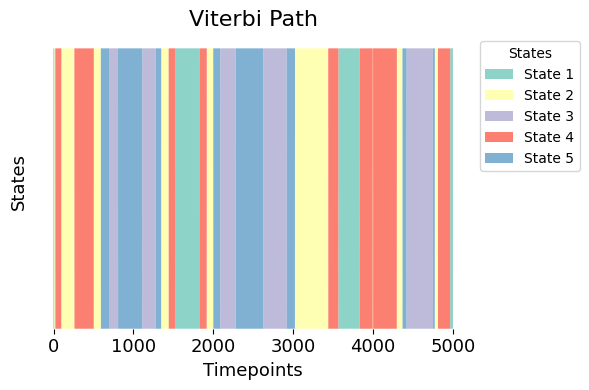

In [6]:
graphics.plot_vpath(vpath, yticks=True, figsize=(6,4), ylabel="States")

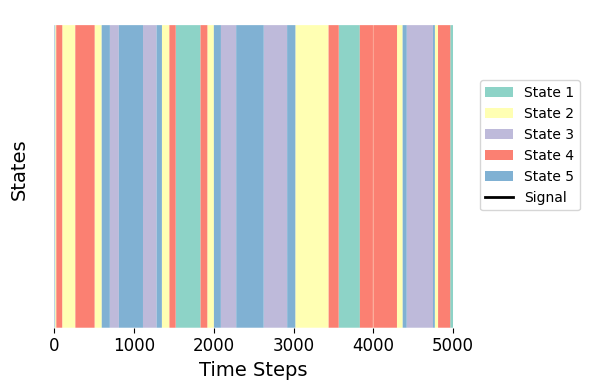

In [11]:
### Original figure by loading the file vpath.npy

**Plot Viterbi path and discrete states**\
We can enhance our visualization by plotting the discrete states alongside the Viterbi path. Similar to our previous plot, this representation illustrates each time point assigned to a specific HMM state, with each state uniquely color-coded.

However, this updated plot introduces an additional layer. At the top of the figure, a secondary plot showcases each state's assignment to a specific value on the y-axis. This value corresponds to a particular HMM state. For instance, if we observe the value 5 on the y-axis, it aligns with the blue color, indicating that this value corresponds to state 5 in our HMM. This figure structure follows the same representation as figure 3D in our paper.

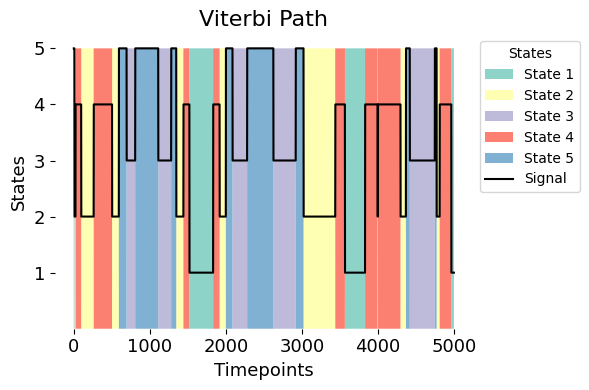

In [7]:
# Create a 1D array from the one-hot encoded Viterbi path data
vpath_1D=statistics.generate_vpath_1D(vpath)
# Convert the signal to be in a range from 0 to 1,
sig_state = vpath_1D/np.max(vpath_1D)
# Plot discrete states with the Viterbi path
graphics.plot_vpath(vpath,sig_state, yticks=True, figsize=(6,4), ylabel="States")

In [8]:
### Original figure by loading the file vpath.npy

**Plot Viterbi path and signal**\
Finally, we can further improve our visualization by plotting the signal (```D```) alongside the Viterbi path (```R```). This representation maintains the color-coded illustration of each time point assigned to a specific HMM state.
To create this plot, it's necessary to normalize the data, ensuring it ranges from 0 to 1 to align with the values of ```vpath```. It's important to note that this normalization is only for visualization purposes, which allow us to overlay the signal with the Viterbi path and gain insights into how well the model captures the underlying dynamics.

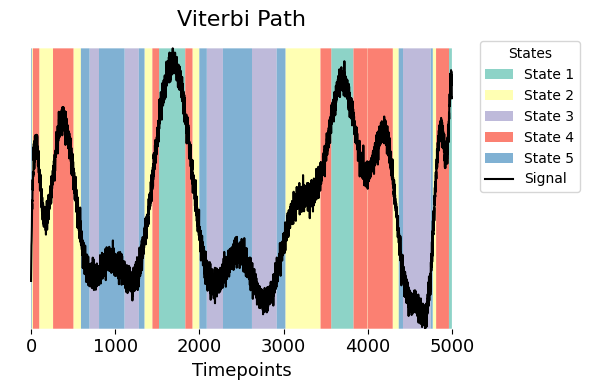

In [9]:
# Normalize the sig_data to the range [0, 1]
min_value = np.min(sig_data)
max_value = np.max(sig_data)
normalized_sig_data = ((sig_data - min_value) / (max_value - min_value))

# Plot vpath and sig_data
graphics.plot_vpath(vpath,normalized_sig_data, figsize=(6,4))

In [10]:
### Original figure by loading the file vpath.npy

Let's delve into the values assigned to each state. To achieve this, we calculate the average of the values associated with each state.

This brief analysis provides insights into the typical or central values characterizing each state. By examining these averages, we gain a clearer understanding of the distinctive characteristics and patterns represented by the different states in our HMM.



In [11]:
K=5
vpath_1D=statistics.generate_vpath_1D(vpath)
val_state =[np.mean(sig_data[vpath_1D == i+1]) for i in range(K) ]
val_state

[4.912042797300882,
 -0.05858422375450776,
 -3.795696791047377,
 2.352225972831181,
 -2.5030418147224505]

In [12]:
### Original figure by loading the file vpath.npy

The above figure shows an relation between the simulated measurements (```sig_data```) and the Viterbi path (```vpath```). Notably, a closer examination of the variable ```val_state``` shows distinct values assigned to each specific state: 

* State 1 (green) aligns with highest value 
* State 2 (yellow) corresponds to values in the middle, close to 0. 
* State 3 (purple) corresponds to the lowest negative values.
* States 4 (red) and State 5 (blue) are values that fall between the extremes values. 
This gives us a perspective on the behavioral dynamics across different states on our signal.

## 2. Permutation testing tutorial - Across-Visits <a id="perm-intro"></a>
As we transition to the next phase of this tutorial, we will learn how to apply the ```across_visits``` function to uncover relationships between HMM state time courses (D) and a continuously measured variable (R) using permutation testing.

**Permutation testing**\
 Permutation testing is a non-parametric resampling technique that assesses statistical significance without assuming any data distribution. By randomly reshuffling measured data, it generates a null distribution, which can be used to test the null hypothesis — that there is no difference or relationship between variables of interest to be tested

### Across visits - Regression <a id="perm-regression"></a>

In regression analysis, we are trying to explain the relationships between predictor variables (D), such as the simulated signal, and the Viterbi path (R).

**Understanding Regression:**\
The objective is to discern the factors contributing to changes in signal values over time. Specifically, by examining the amount of explained variance, it can be used to analyze whether the Viterbi path, characterized by different states, plays a significant role in explaining the observed variability in signal values over time.

**Permutation Test for Explained Variance:**\
The permutation test for explained variance is a useful method to assess the statistical significance of relationships between the signal (D) and the Viterbi path (R). A significant result implies that specific states in the Viterbi path contribute significantly to explaining why signal values vary over time. A non-significant result, on the other hand, suggests that the observed relationship can be attributed to random chance, implying that the Viterbi path may not play a significant role in accounting for the signal's variability.

**Explore data**\
First, let us look at the data that we are interested in:

In [13]:
print(f"Data dimension of simulated signal: {sig_data.shape}")
print(f"Data dimension of viterbi path: {vpath.shape}")

Data dimension of simulated signal: (5000, 1)
Data dimension of viterbi path: (5000, 5)


In this example, simulated signal, represented as a 5000x1 array, is a continuous variable.\ The corresponding  Viterbi path is a 5000x4 matrix, representing discrete states for each time point based on a simulated path. Each state is one-hot encoded as a binary vector.\
Running the ```across_visits``` function requires providing inputs: ```D_data``` (the simulated signal) and ```R_data``` (the Viterbi path, defined with five states - n_states = 4 in this case). To initiate regression-based permutation testing, set ```method="regression"```.\
For a deeper look at the function look at the documentation.

In [15]:
# Set the parameters for across_visits testing
method = "multivariate"
Nperm = 1000 # Number of permutations (default = 1000)
n_states = 5
result_regression  =statistics.test_across_visits(sig_data, vpath, method=method,Nperm=Nperm, n_states=n_states)

100%|██████████| 1000/1000 [00:14<00:00, 68.37it/s]


We can now examine the local ```result_regression``` variable.

In [16]:
result_regression

{'pval': array([0.000999  , 0.5984016 , 0.000999  , 0.07392607, 0.16683317]),
 'base_statistics': array([ 0.25809757, -0.2418971 ,  0.10965456, -0.09223528, -0.12089887]),
 'test_statistics': [],
 'test_type': 'test_across_visits',
 'method': 'multivariate',
 'max_correction': False,
 'performed_tests': {'t_test_cols': [], 'f_anova_cols': [], 'f_reg_cols': []},
 'Nperm': 1000}

What we can see here is that ```result_regression``` is a dictionary that contains the output of a statistical analysis applied using the specified ```method``` and ```test type```. 

Let us break it down:\ 

* ```pval```: This array holds the p-values resulting from the permutation test.

* ```corr_coef```: Currently an empty list. It is intended to store correlation coefficients if correlation is involved in the analysis. In this case, the correlation coefficients are not calculated when we have set ```method="regression"```. 

* ```test_statistic```: Currently an empty list. This list could can store the test statistics associated with the permutation test. It provides additional information about the permutation distribution that is used to calculate the p-values. The output will exported if we set ```test_statistic_option=True```

* ```pval_list```: This list is currently empty. It stores the p-values concurrently calculated with correlation coefficients when ```method = "correlation_com"``` using the [scipy.stats.pearsonr](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html) module.
Note: ```"correlation_com"``` stands for correlation combined and provides both the statistical significance of Pearson's correlation coefficient and a 2-tailed p-value. The output is exported when ```method = "correlation_com"``` and ```test_statistic_option=True```

* ```test_type```: Indicates the type of permutation test performed. In this case, it is ```across_visits```.

* ```method```: Specifies the method employed in the analysis. Here, it is ```'regression'```, indicating that the analysis is conducted using regression-based permutation testing.

**Visualization of results**\
Now that we have performed our test, we can then visualize the p-value array.\
We will import the function ```plot_p_values_bar``` from module ```graphics.py```

In [17]:
# Plot p-values
graphics.plot_p_values_bar(result_regression["pval"], title_text ="P-value for explained variance",
                      figsize=(3, 3), alpha=0.05, variables=[""])

TypeError: plot_p_values_bar() got an unexpected keyword argument 'variables'

**Conclusion - Regression**\
The permutation test for explained variance indicated that there is insufficient evidence to reject the null hypothesis. 
We can see that the base_statistic is negative (```'base_statistics': -5.85```). This suggests that the model is performing worse than a simple horizontal line representing the mean of the dependent variable. Hence, the model is not capturing the variance in the data and may be providing predictions that are systematically worse than using the mean and is therefore not an ideal statistics to apply on this dataset. The categorical and discrete structure of the Viterbi path complicates the interpretation. Traditional statistical approaches, particularly those based on continuous variables, may not be immediately relevant or may lose sensitivity when applied to discrete sequences.

Alternatively, we can employ F-statistics on the Hidden Markov Model (HMM) states and showed a significant difference, and therefore suggests variation in HMM states. A significant F-statistic implies that there are substantial differences in the means of these states. However, it is important to note that while the F-statistics test shows a significant difference, it does not provide detailed insights into the specific nature of these differences between states.

### Across visits - Univariate test <a id="perm-correlation"></a>
In univariate test analysis, we are interested in understanding the impact of discrete states in the Viterbi path (R_data) on the variability observed in the signal (D_data).

The goal is to assess the statistical significance of the relationship between specific states in the Viterbi path and the variations in continuous signal values over time using a permutation test. This across visits test helps us determine whether certain states in the Viterbi path significantly contribute to the observed variations in signal values. Conversely, a non-significant result suggests that the observed relationship may be due to random chance, and the Viterbi path may not significantly influence the signal's variability.

To execute the across_visits function successfully, you must provide inputs in the form of ```D_data``` and ```R_data```. In this case, the desired number of states is specified as five (n_states = 5). The function employs univariate testing based on correlation by default, but can perform t-test or f-test by setting ```identify_categories=True``` or define the column of interest that should contain categorical values.

Additionally, we enable the export of the permutation distribution by setting test_statistic_option=True.


In [18]:
# Set the parameters for across_visits testing
method = "univariate"
Nperm = 1000
n_states = 5
test_statistics_option=True
result_univariate  =statistics.test_across_visits(sig_data, vpath, method=method,Nperm=Nperm,test_statistics_option=test_statistics_option, n_states=n_states)

100%|██████████| 1000/1000 [00:14<00:00, 69.26it/s]


We can now examine the local ```result_univariate``` variable.

In [19]:
result_univariate

{'pval': array([0.000999  , 0.92207792, 0.001998  , 0.01398601, 0.04395604]),
 'base_statistics': array([ 0.63053061,  0.02544851, -0.62533888,  0.48084955, -0.39815568]),
 'test_statistics': array([[0.63053061, 0.02544851, 0.62533888, 0.48084955, 0.39815568],
        [0.45862168, 0.02643508, 0.17540093, 0.01821764, 0.13414227],
        [0.20537471, 0.18029614, 0.29124   , 0.14512027, 0.12921579],
        ...,
        [0.12949939, 0.15112702, 0.0884273 , 0.05907467, 0.10106995],
        [0.04686277, 0.07974739, 0.20219946, 0.07057764, 0.05824315],
        [0.22531785, 0.23534414, 0.16446369, 0.00524758, 0.09690715]]),
 'test_type': 'test_across_visits',
 'method': 'univariate',
 'max_correction': False,
 'performed_tests': {'t_test_cols': [], 'f_anova_cols': [], 'f_reg_cols': []},
 'Nperm': 1000}

Now that we have the permutation distribution ['test_statistic] as we can see, it is because we set ```test_statistic_option=True```

**Visualization of results**\
Now that we have performed our test, we can then visualize the p-value array.
We will import the function ```plot_heatmap```, ```plot_scatter_with_labels``` and ```plot_histograms``` from module ```helperfunctions.py```

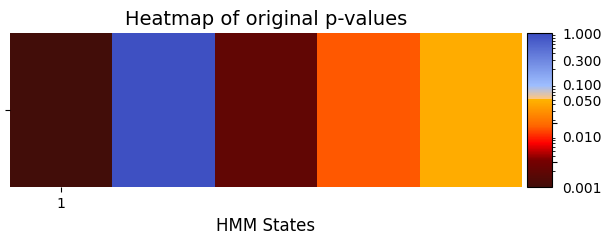

In [20]:
# Plot p-values
graphics.plot_p_value_matrix(result_univariate["pval"], title_text ="Heatmap of original p-values",figsize=(7, 2), xlabel="HMM States", ylabel="", alpha=0.05)

**Multiple Comparison**\
To be sure there is no type 1 error, we can apply the Benjamini/Hochberg to control the False Discovery Rate

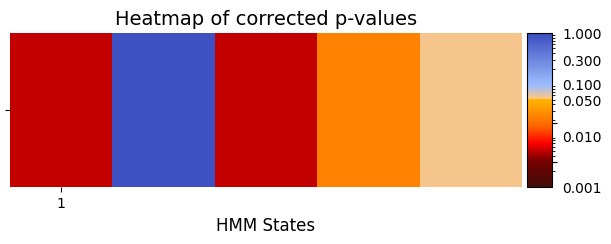

In [21]:
pval_corrected, rejected_corrected =statistics.pval_correction(result_univariate["pval"], method='fdr_bh')
# Plot p-values
graphics.plot_p_value_matrix(pval_corrected, title_text ="Heatmap of corrected p-values",figsize=(7, 2), xlabel="HMM States", ylabel="")

Instead of using a heatmap, we can also visualize the results with a bar plot

In [22]:
# Set the threshold of alpha to be 0.05
alpha = 0.05
variables = [f"State {i+1}" for i in range(len(pval_corrected))] # construct the variable names
graphics.plot_p_values_bar(pval_corrected,alpha = alpha, variables=variables)

TypeError: plot_p_values_bar() got an unexpected keyword argument 'variables'

**Plot permutation distribution**\
Presented here are the test statistics(```result["test_statistic"]```) of our permutation distributions for different states.\
The red line shows the observed statistic, while the datapoints of the histogram represent the permutation distribution

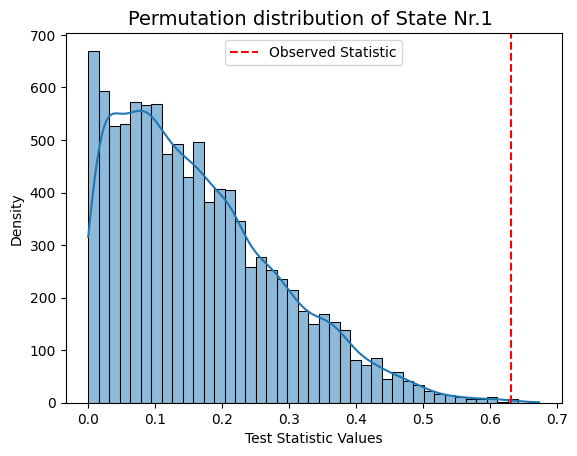

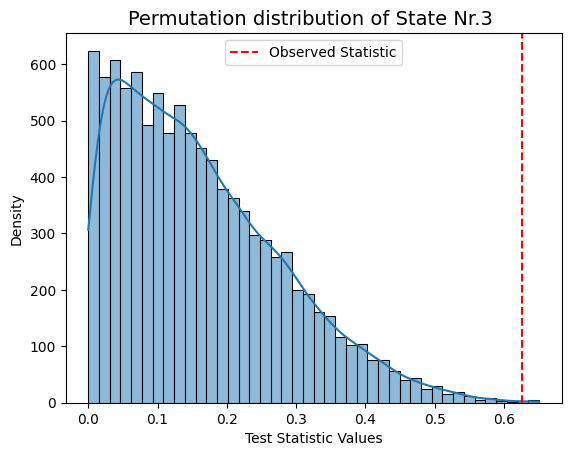

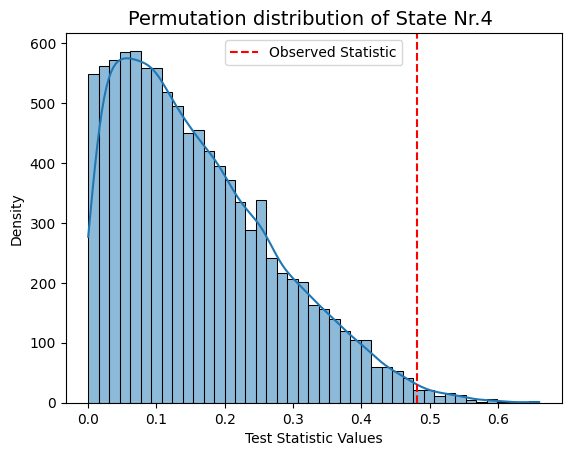

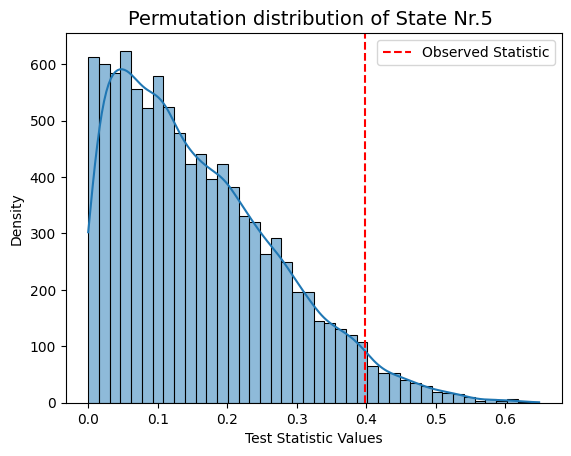

In [ ]:
# Plot test statistics for pvals
significant_timestamp_position = np.where(pval_corrected < alpha)
for i in significant_timestamp_position[0]:
    graphics.plot_permutation_distribution(result["test_statistics"][:,i],title_text=f"Permutation distribution of State Nr.{i+1} ")

### Conclusion - Correlation
The p-value array reveals a significant result for states 1, 3 and 4 while the state 2 and 5 do not exhibit statistical significance. This outcome suggests that the discrete states (1, 3 and 4) of the Viterbi path (R) play a meaningful role in explaining variations in the signal (D).
Considering the signal characteristics, where the highest peak corresponds to state 1, the lowest peak to state 3, and the second-highest to state 4 this alignment reinforces the significance observed. 

It suggests that the distinct states, especially those with extreme signal values have a significant impact in shaping the variability of the signal.
 
Conversely, the lack of significance for states 2 and 5 implies that their influence may be more nuanced or less pronounced in explaining the observed variations in the signal.


## Across visits - One vs rest <a id="perm-rest"></a>
In the permutation test comparing one state against the rest (one vs rest), we analyze the mean signal difference between a specific state (e.g., state 1) and the combined influence of the other states.
This approach assesses whether a particular state significantly differs from the collective impact of the remaining states in shaping signal values over time. In other words, the permutation test for mean difference allows us to discern if the observed variations in the signal (D) are statistically significant for a specific state compared to the aggregate effect of the other states.\
A significant result suggests that the distinctive characteristics of that particular state contribute significantly to the observed variations in the signal. Conversely, a non-significant result implies that the observed difference may be attributed to random chance, indicating that the specific state might not play a substantial role in accounting for the variability in the signal compared to the rest.

This test can help identify physiological states that significantly differ from the combined influence of other states. Consequently, it proves valuable in understanding the specific impact of a particular physiological state on a measured variable. Consider a study on heart rate variability across different states of arousal; this test has the potential to identify states that distinctly influence on heart rate or other hypotheses on the subject.

In [23]:
# Set the parameters for across_visits testing
method = "one_vs_rest"
Nperm = 1_000
test_statistics_option=True
n_states = 5

result_one_vs_rest  =statistics.test_across_visits(sig_data, vpath, method=method,Nperm=Nperm,test_statistics_option=test_statistics_option, n_states=n_states)

100%|██████████| 1000/1000 [00:14<00:00, 69.17it/s]


**Visualization of results**\
Now that we have performed our test, we can then visualize the p-value array.
We will plot the p-values using the function ```plot_p_value_matrix```

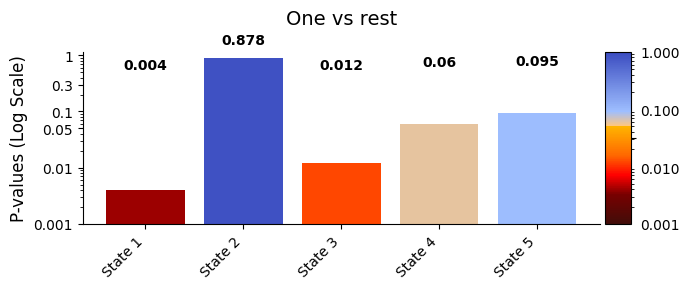

In [29]:
# Set the threshold of alpha to be 0.05
alpha = 0.05
variables = [f"State {i+1}" for i in range(len(pval_corrected))] # construct the variable names
title_text = "One vs rest"
graphics.plot_p_values_bar(result_one_vs_rest["pval"],alpha = alpha, xticklabels=variables, title_text=title_text,figsize=(7, 3))

**Multiple Comparison**\
Applying p-value correction using Bonferroni to take into account the risk of type 1 errors (false positive) due to multiple testing.

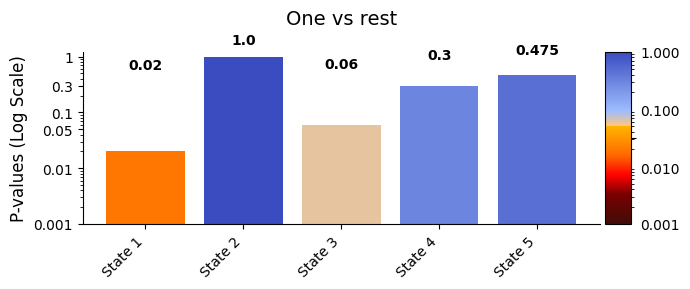

In [30]:
pval_corrected, _ =statistics.pval_correction(result_one_vs_rest["pval"], method='bonferroni')
# Plot p-values
graphics.plot_p_values_bar(pval_corrected,alpha = alpha, xticklabels=variables, title_text=title_text,figsize=(7, 3))


### Conclusion - One vs rest
What it shows here is that the significant different p-values (state 1 and 3) correspond to the states with the highest and lowest values in the signal (```sig_data```). In the context of the "one vs rest" comparison, where each state is compared against the rest combined, a significant p-value indicates that the mean signal difference for that specific state is statistically different from the combined impact of the other states. Therefore, the highest and lowest p-values suggest that these two states significantly contribute to the observed variations in the signal, indicating their distinctive impact compared to the rest of the states.

## 9. Across visits - State pairs <a id="perm-pairs"></a>
In the permutation test comparing state pairs, we analyze the mean signal difference between different pairs of states (e.g., state 1 vs. state 2, state 1 vs. state 3, etc.).
This procedure studies whether the mean signal difference between specific state pairs is statistically significant. 

A significant result for a specific state pair implies that the mean signal difference between those states affects the observed variations in the signal. Conversely, a non-significant result suggests that the observed difference between those specific states might not play a substantial role in explaining the variability in the signal.
This can be useful when examining how physiological signals change during transitions between different states. For example, in studies on pain response, comparing mean differences between baseline and stress-induced states can provide insights into the physiological dynamics during transitions.

In [38]:
# Set the parameters for across_visits testing
method = "state_pairs"
Nperm = 1000
test_statistics_option=True
n_states = 5

result_state_pairs  =statistics.test_across_visits(sig_data, vpath, method=method,Nperm=Nperm,test_statistics_option=test_statistics_option, n_states=n_states)

Pairwise comparisons:  40%|████      | 4/10 [00:49<01:14, 12.40s/it]

Unexpected exception formatting exception. Falling back to standard exception



Traceback (most recent call last):
  File "C:\Users\au323479\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py", line 3460, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\au323479\AppData\Local\Temp\ipykernel_3860\2005184322.py", line 7, in <module>
    result_state_pairs  =statistics.test_across_visits(sig_data, vpath, method=method,Nperm=Nperm,test_statistics_option=test_statistics_option, n_states=n_states)
  File "C:\Users\au323479\AppData\Roaming\Python\Python39\site-packages\glhmm\statistics.py", line 852, in test_across_visits
  File "C:\Users\au323479\AppData\Roaming\Python\Python39\site-packages\glhmm\statistics.py", line 1685, in surrogate_state_time
    else:
  File "C:\Users\au323479\AppData\Roaming\Python\Python39\site-packages\glhmm\statistics.py", line 1773, in surrogate_viterbi_path
  File "<__array_function__ internals>", line 200, in all
  File "C:\Users\au323479\AppData\Roaming\Python\Python39\site-pac

In [36]:
result_state_pairs["test_statistics"].shape

(1000, 10)

**Visualization of results**\
Now that we have performed our test, we can then visualize the p-value array.
We will plot the p-values using the function ```plot_heatmap```. Notably, in this instance, we designate the values on the diagonal as NaN (Not a Number) since these values are expected to be zeros and can be safely ignored in the visualization.

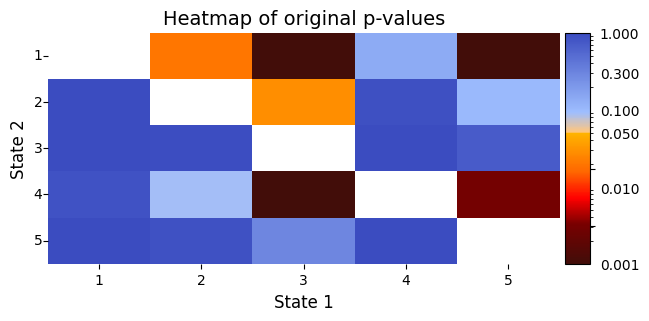

In [34]:
# Plot p-values# Plot p-values
graphics.plot_p_value_matrix(result_state_pairs["pval"], title_text ="Heatmap of original p-values",figsize=(7, 3), xlabel="State 1", ylabel="State 2", alpha=0.05, none_diagonal=True)

**Interpret the p-value matrix**\
The matrix has a shape of (number of states by number of states), and the values below the diagonal (lower-left) represent comparisons where the lower state number is less than the higher state number. Values above the diagonal (upper-right) represent comparisons where the lower state number is greater than the higher state number.

**Multiple Comparison**\
Now we can apply p-value correction using Bonferroni to control the risk of type 1 error (false positive).

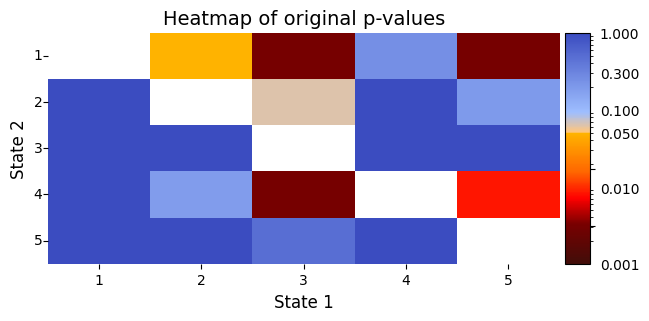

In [35]:
pval_corrected, rejected_corrected =statistics.pval_correction(result_state_pairs["pval"], method='fdr_bh')
# Plot p-values# Plot p-values
graphics.plot_p_value_matrix(pval_corrected, title_text ="Heatmap of original p-values",figsize=(7, 3), xlabel="State 1", ylabel="State 2", alpha=0.05, none_diagonal=True)

In [52]:
# Look at the val_sates values
val_state

[4.912042797300882,
 -0.05858422375450776,
 -3.795696791047377,
 2.352225972831181,
 -2.5030418147224505]

### Conclusion - state pairs
In the p-value matrix resulting from the permutation test for state pairs, where the majority of values are negative, exceptions include pairs 2 vs 1, 3 vs. 1, 3 vs 2, 4 vs. 3, 5 vs. 4, and 5 vs. 1. These exceptions signify statistically significant mean signal differences for the corresponding state pairs.

* State 1, with the highest value, exhibits a significant difference when compared with states 2, 3 and 5.
* State 3, holding the lowest value, signifies a significant difference when compared with states 1, 2 and 4.
* States 4 and 5, positioned between the extreme values, demonstrate a significant mean signal difference when paired with each other. Additionally, there is a significant difference between 5 and 1, the second lowest and highest numbers, respectively.

This suggests that these specific state pairs play a role in explaining the variability in the signal, and this could potentially provide valuable insights into how physiological signals change during transitions between different states, e.g. pain response studies.